In [1]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.tsatools import lagmat
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

In [2]:
import gc
gc.collect()

11

In [3]:
path = Path('data/web-traffic/')

In [4]:
list(path.iterdir())

[PosixPath('data/web-traffic/key_1.csv'),
 PosixPath('data/web-traffic/sample_submission_1.csv'),
 PosixPath('data/web-traffic/sample_submission_2.csv'),
 PosixPath('data/web-traffic/train_2.csv'),
 PosixPath('data/web-traffic/key_2.csv'),
 PosixPath('data/web-traffic/train_1.csv')]

In [6]:
train = pd.read_csv(path/'train_1.csv')
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [27]:
len(train.columns), len(train.columns[-550:])

(551, 550)

In [ ]:
train_flattened = pd.melt(train[list(train.columns[-550:])+['Page']], 
                          id_vars='Page', var_name='date', value_name='Visits')

train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

In [22]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,std,weekday,year,month,day,month_num,weekday_num
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,1.675148,06 - Saturday,2016,11,12,11,5
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,1.675148,07 - Sunday,2016,11,13,11,6
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,1.675148,01 - Monday,2016,11,14,11,0
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1.675148,02 - Tuesday,2016,11,15,11,1
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,1.675148,03 - Wednesday,2016,11,16,11,2


In [23]:
train_flattened.shape

(7253150, 13)

In [8]:
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']

df_mean   = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']

df_std    = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].std())
df_std.columns = ['std']

train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median).join(df_std)

In [9]:
train_flattened.reset_index(drop=False, inplace=True)

In [10]:
train_flattened['weekday'] = train_flattened['date'].apply(lambda x: x.weekday())

In [11]:
train_flattened['year'] = train_flattened.date.dt.year
train_flattened['month'] = train_flattened.date.dt.month
train_flattened['day'] = train_flattened.date.dt.day

In [12]:
train_flattened.head()

,Page,date,Visits,weekend,mean,median,std,weekday,year,month,day
0,!vote_en.wikipedia.org_all-access_all-agents,2016-11-12,2.0,1.0,2.836735,2.0,1.675148,5,2016,11,12
1,!vote_en.wikipedia.org_all-access_all-agents,2016-11-13,2.0,1.0,2.836735,2.0,1.675148,6,2016,11,13
2,!vote_en.wikipedia.org_all-access_all-agents,2016-11-14,4.0,0.0,2.836735,2.0,1.675148,0,2016,11,14
3,!vote_en.wikipedia.org_all-access_all-agents,2016-11-15,8.0,0.0,2.836735,2.0,1.675148,1,2016,11,15
4,!vote_en.wikipedia.org_all-access_all-agents,2016-11-16,3.0,0.0,2.836735,2.0,1.675148,2,2016,11,16


In [13]:
train_flattened.sample(10)

,Page,date,Visits,weekend,mean,median,std,weekday,year,month,day
5480280,Хоккей_с_шайбой_ru.wikipedia.org_desktop_all-a...,2016-12-12,480.0,0.0,434.580000,437.5,93.715830,0,2016,12,12
6711629,狼王子_zh.wikipedia.org_desktop_all-agents,2016-12-11,882.0,1.0,593.080000,541.0,228.049569,6,2016,12,11
4545224,User:K'm_commons.wikimedia.org_all-access_spider,2016-12-06,0.0,0.0,1.216216,1.0,1.031049,1,2016,12,6
4683909,Wikimedia_Apps/iOS_FAQ_www.mediawiki.org_deskt...,2016-11-21,37.0,0.0,10.820000,9.0,7.474282,0,2016,11,21
5808611,一拳超人_zh.wikipedia.org_desktop_all-agents,2016-11-23,758.0,0.0,984.800000,950.0,194.982888,2,2016,11,23
4303340,The_Big_Short_(Film)_de.wikipedia.org_all-acce...,2016-12-22,5.0,0.0,7.960000,7.0,6.913341,3,2016,12,22
2977038,Manual:LocalSettings.php_www.mediawiki.org_des...,2016-12-20,107.0,0.0,94.680000,100.5,26.628541,1,2016,12,20
868067,Celebrity_Big_Brother_18_en.wikipedia.org_all-...,2016-11-29,23.0,0.0,20.560000,13.0,18.770537,1,2016,11,29
776504,Category:MediaWiki_Introduction_www.mediawiki....,2016-11-16,2.0,0.0,5.020000,4.0,2.846337,2,2016,11,16
764531,Category:Labeled_photographs_of_human_female_g...,2016-12-13,68.0,0.0,77.360000,69.5,28.798923,1,2016,12,13


## Aggregation & Visualisation

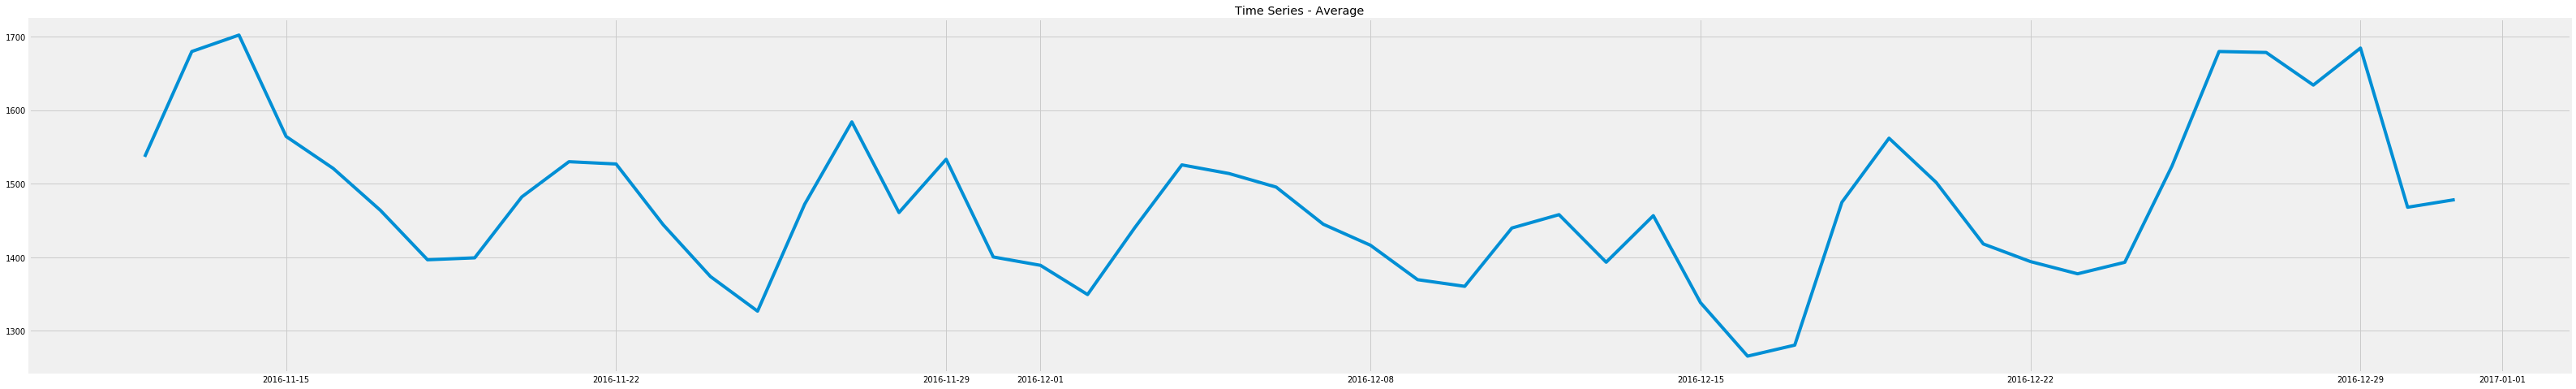

In [16]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page', 'date', 'Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

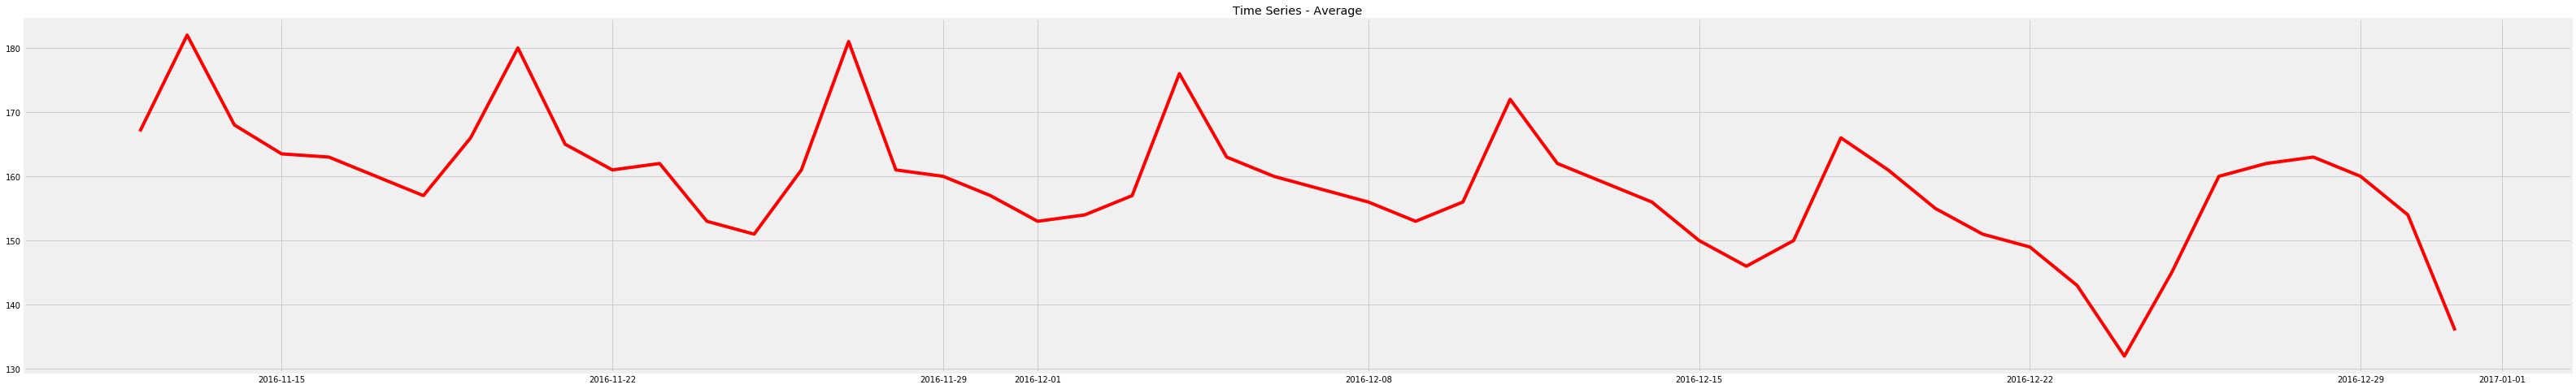

In [17]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page', 'date', 'Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color='r')
plt.title('Time Series - Average')
plt.show()

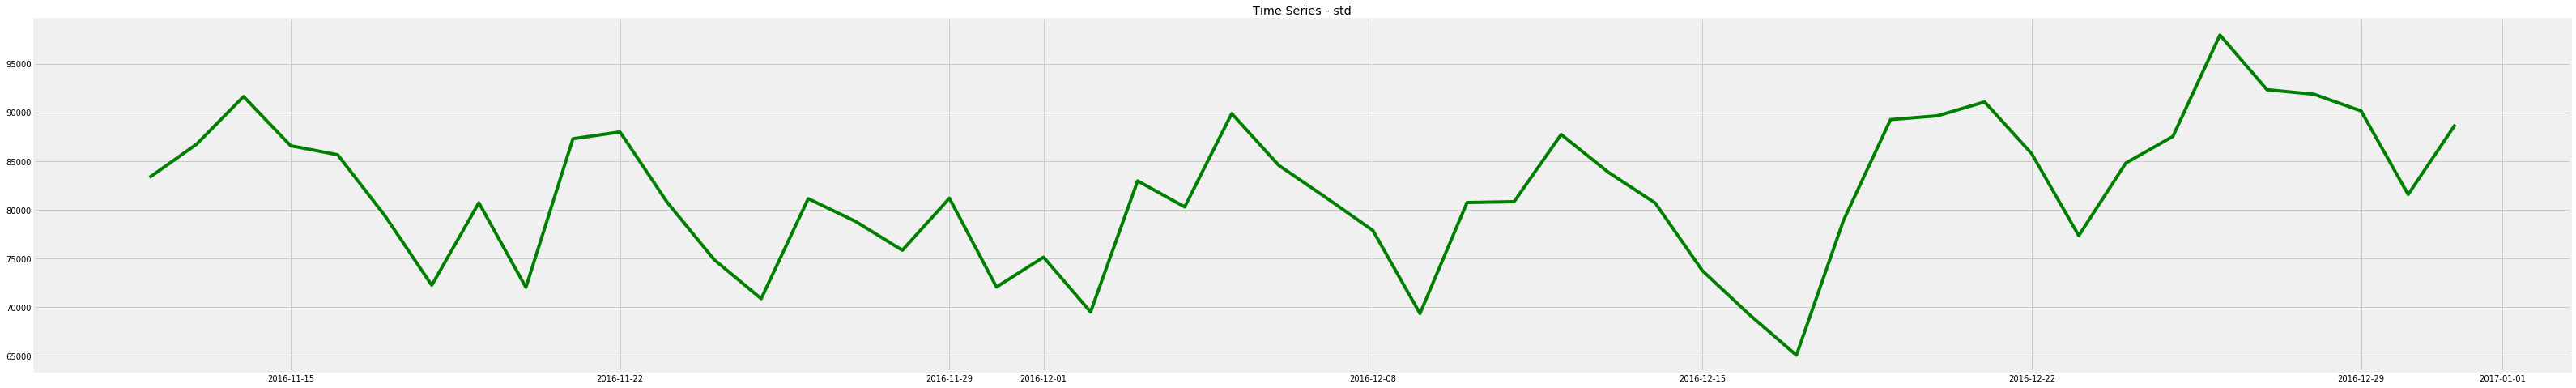

In [18]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

In [19]:
train_flattened['month_num'] = train_flattened['month']
train_flattened['month'].replace('11', '11 - November', inplace=True)
train_flattened['month'].replace('12', '12 - December', inplace=True)

train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

In [20]:
train_group = train_flattened.groupby(['month', 'weekday'])['Visits'].mean().reset_index()

train_group = train_group.pivot('weekday', 'month', 'Visits')
train_group.sort_index(inplace=True)

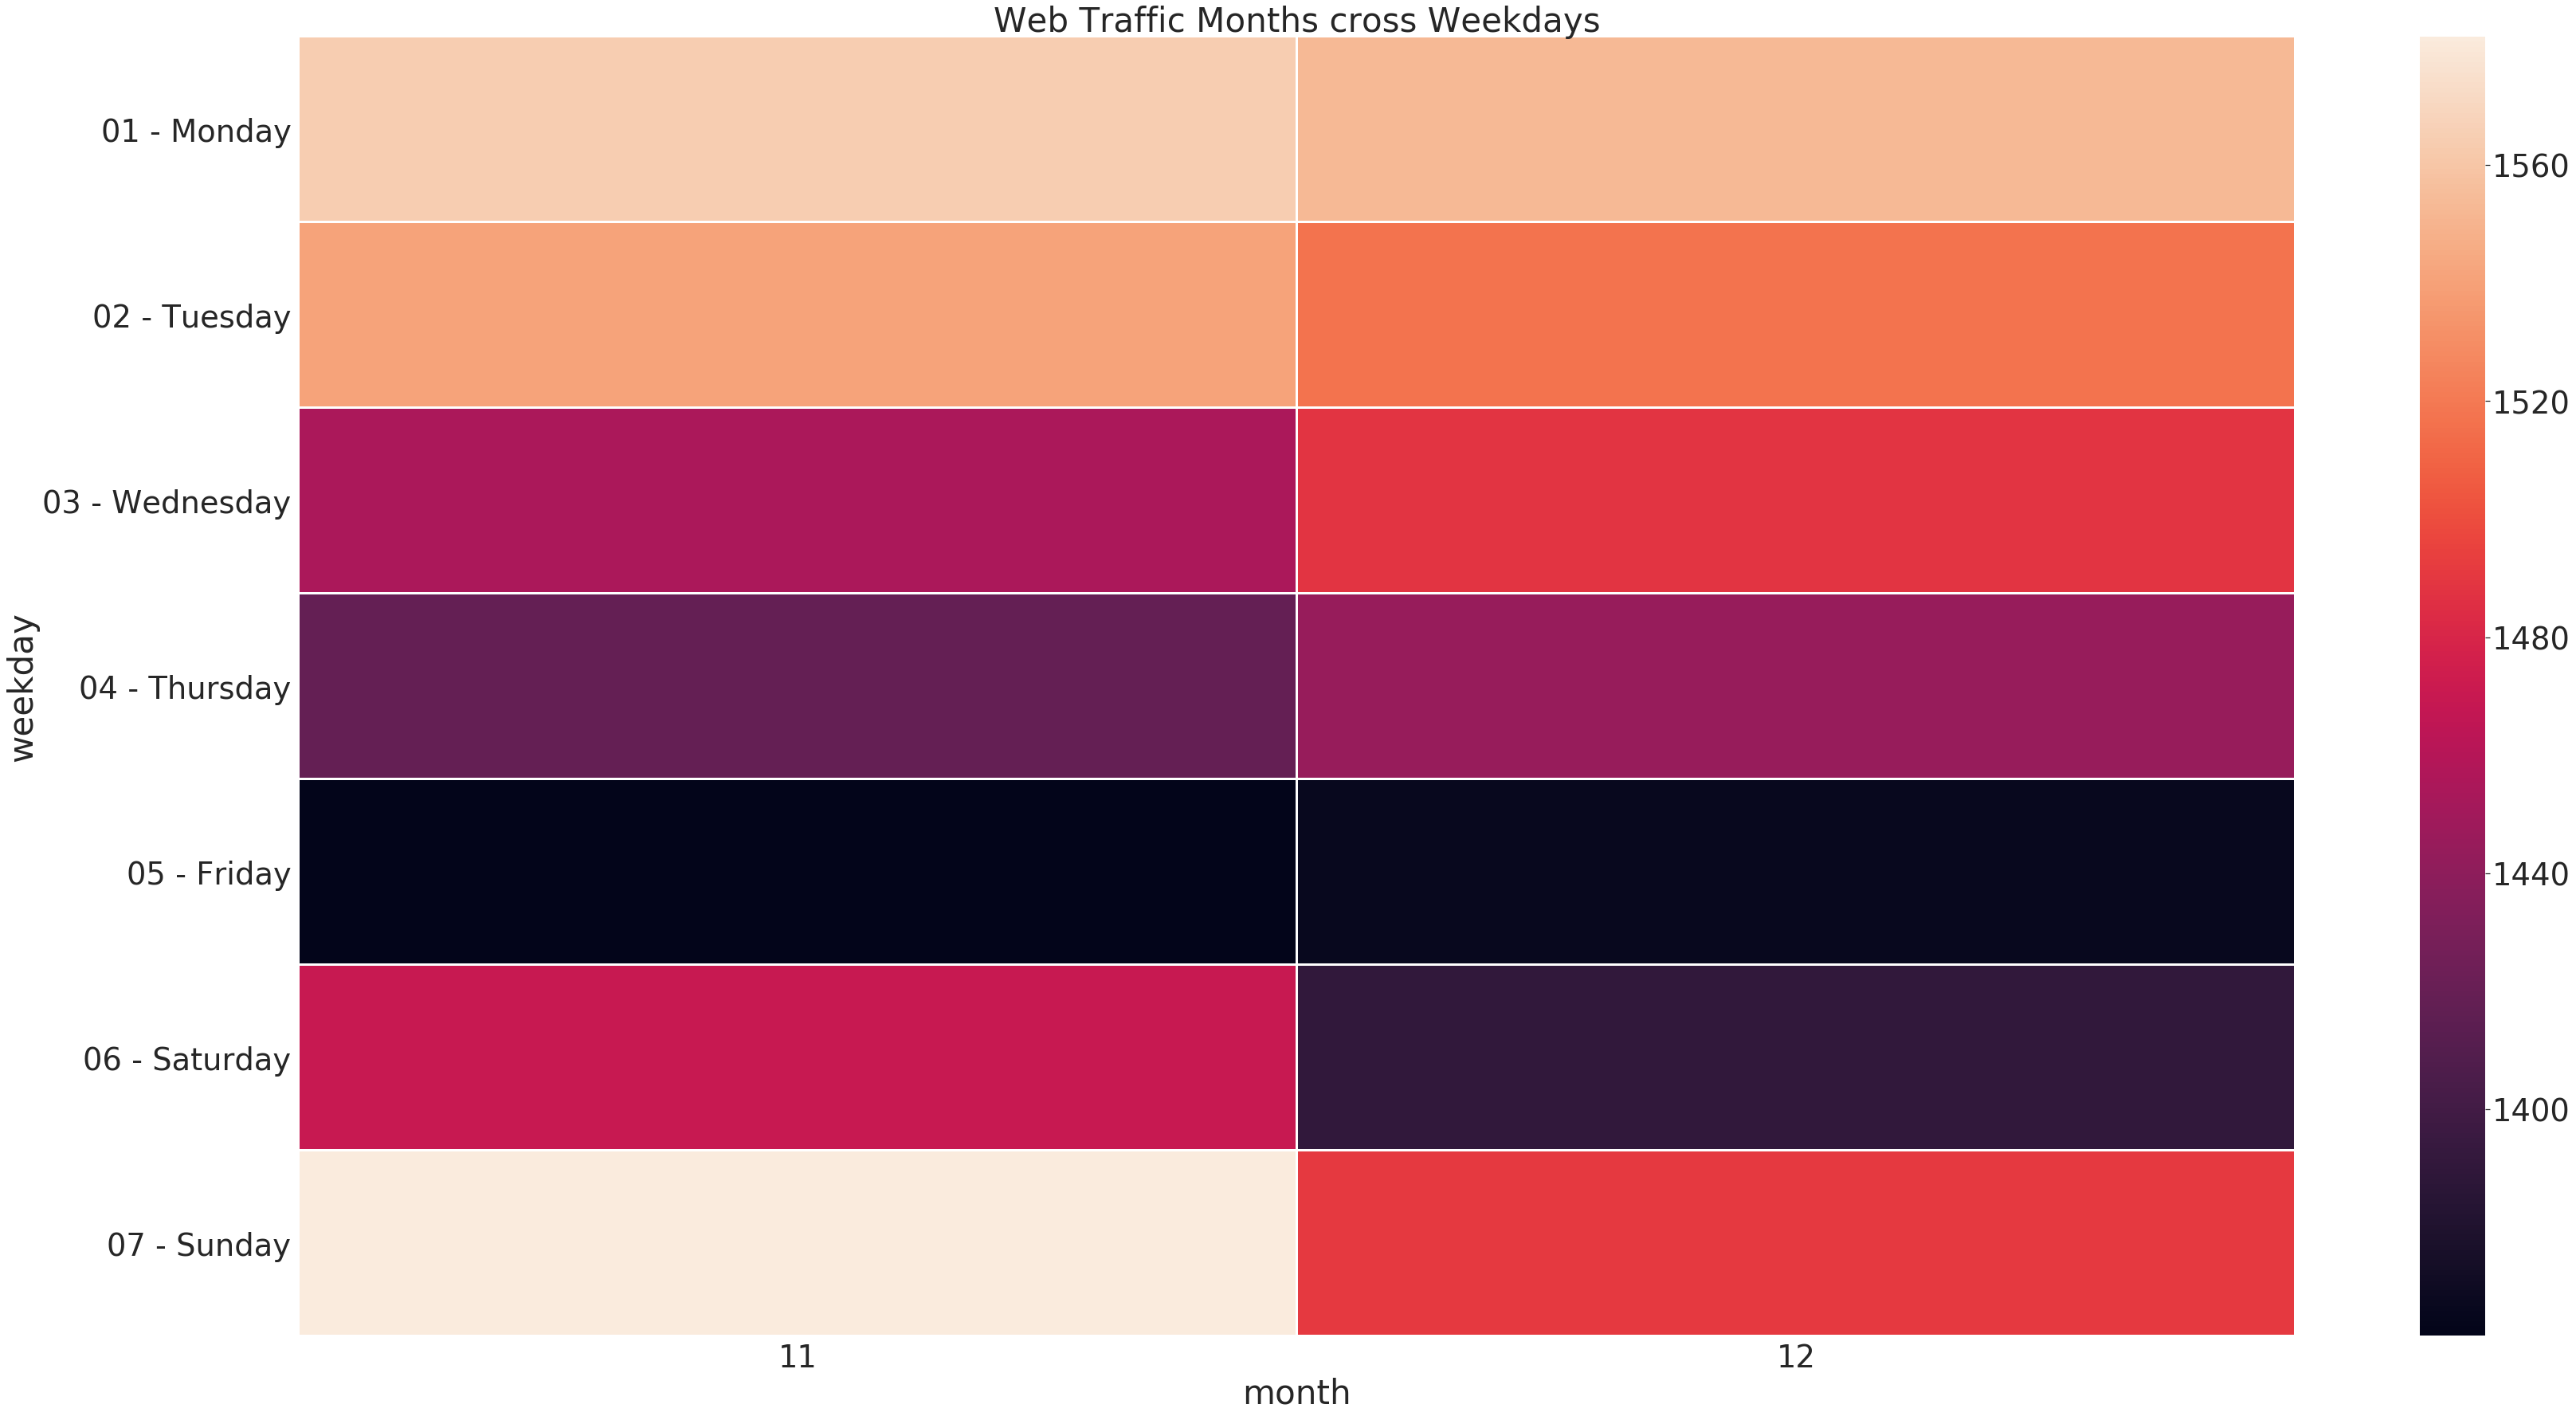

In [21]:
sns.set(font_scale=3.5)

f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt='d', linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

In [21]:
train_day = train_flattened.groupby(['month', 'day'])['Visits'].mean().reset_index()

train_day = train_day.pivot('day', 'month', 'Visits')
train_day.sort_index(inplace=True)
train_day.dropna(inplace=True)

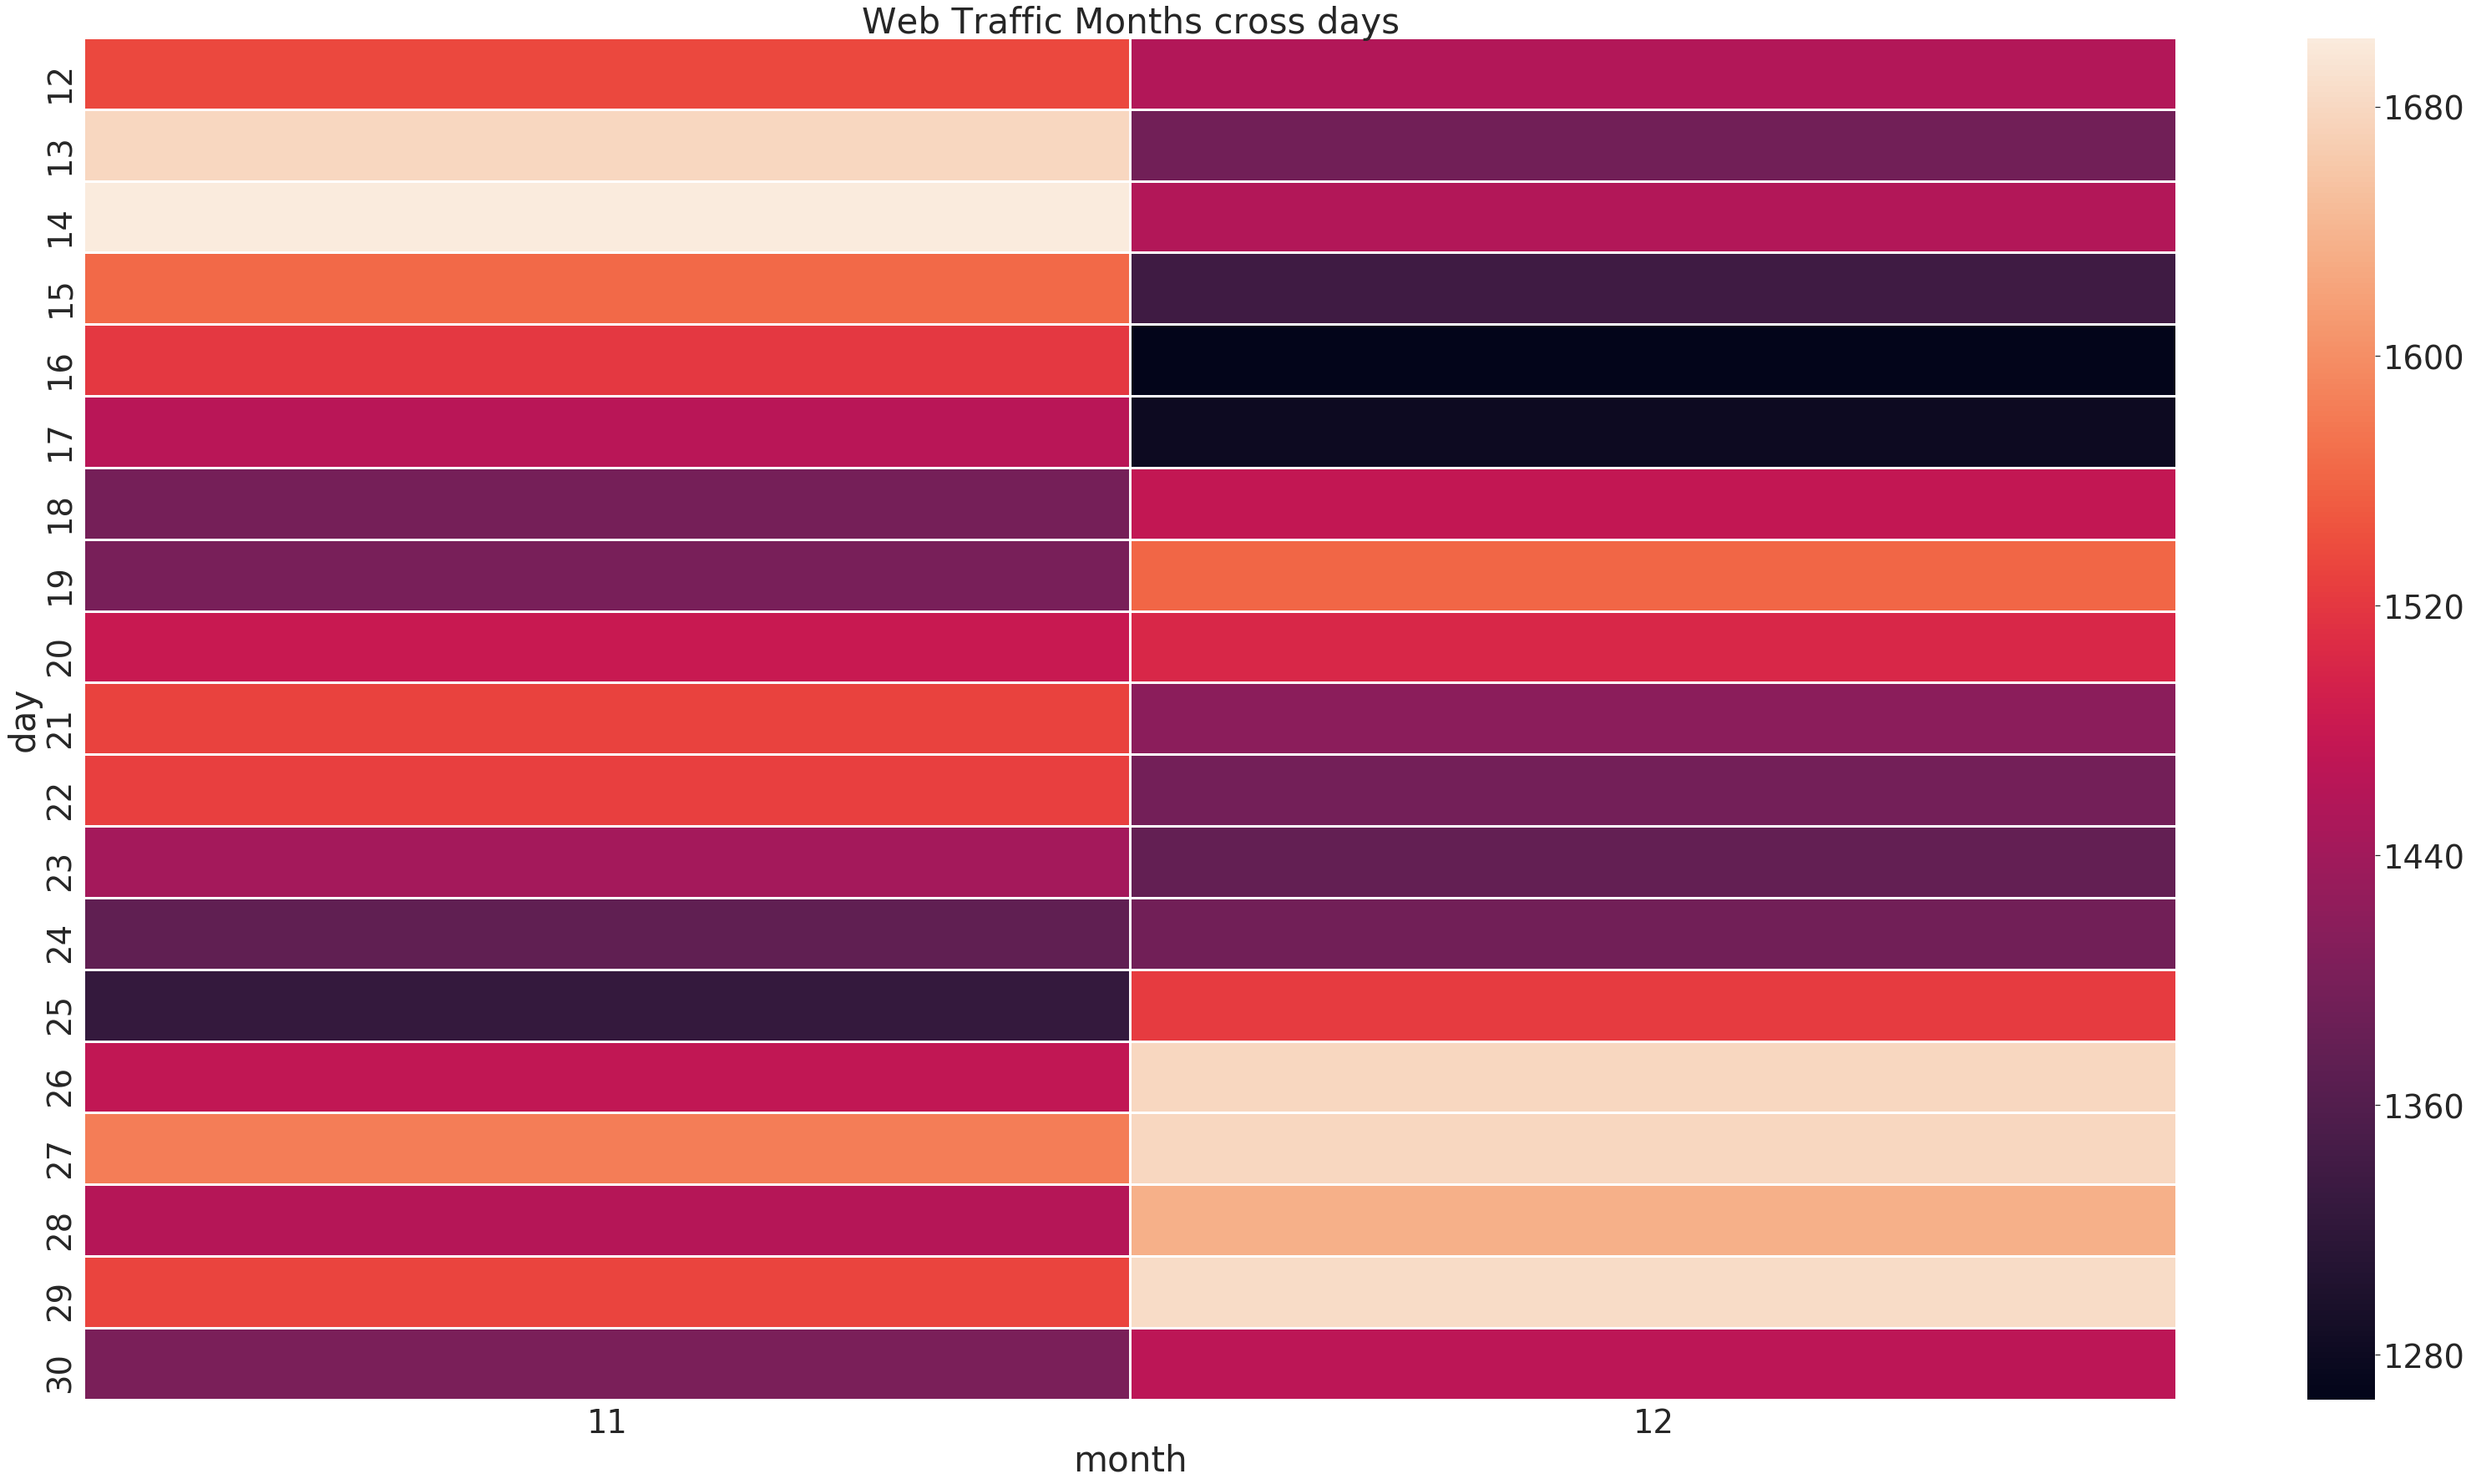

In [22]:
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt='d', linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()

## ML Approach

In [23]:
times_series_means = pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].apply(lambda x: x.weekday())

times_series_means['Date_str'] = times_series_means['date'].apply(lambda x: str(x))

times_series_means[['year', 'month', 'day']] = pd.DataFrame(times_series_means['Date_str'].str.split('-', 2).tolist(), columns=['year', 'month', 'day'])

date_staging = pd.DataFrame(times_series_means['day'].str.split(' ', 2).tolist(), columns=['day', 'other'])

times_series_means['day'] = date_staging['day'] * 1
times_series_means.drop('Date_str', axis=1, inplace=True)
times_series_means.head()

,date,Visits,weekday,year,month,day
0,2016-11-12,1536.471757,5,2016,11,12
1,2016-11-13,1679.630589,6,2016,11,13
2,2016-11-14,1701.941831,0,2016,11,14
3,2016-11-15,1564.172228,1,2016,11,15
4,2016-11-16,1520.673959,2,2016,11,16


In [24]:
times_series_means.reset_index(drop=True,inplace=True)

In [25]:
def lag_func(data, lag):
    lag = lag
    X = lagmat(data['diff'], lag)
    lagged = data.copy()
    for c in range(1, lag+1):
        lagged['lag%d' % c] = X[:, c-1]
    return lagged

def diff_creation(data):
    data['diff'] = np.nan
    data.ix[1:, 'diff'] = (data.iloc[1:, 1].as_matrix() - data.iloc[:len(data)-1, 1].as_matrix())
    return data

df_count = diff_creation(times_series_means)

lag = 7
lagged = lag_func(df_count, lag)
last_date = lagged['date'].max()

In [64]:
lagged.head()

,date,Visits,weekday,year,month,day,diff,lag1,lag2,lag3,lag4,lag5,lag6,lag7
0,2016-11-12,1536.471757,5,2016,11,12,NaN,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2016-11-13,1679.630589,6,2016,11,13,143.158833,NaN,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2016-11-14,1701.941831,0,2016,11,14,22.311241,143.158833,NaN,0.000000,0.0,0.0,0.0,0.0
3,2016-11-15,1564.172228,1,2016,11,15,-137.769602,22.311241,143.158833,NaN,0.0,0.0,0.0,0.0
4,2016-11-16,1520.673959,2,2016,11,16,-43.498270,-137.769602,22.311241,143.158833,NaN,0.0,0.0,0.0


In [27]:
def train_test(data_lag):
    xc = ["lag%d" % i for i in range(1, lag+1)] + ['weekday'] + ['day']
    split = 0.70
    xt = data_lag[(lag+1):][xc]
    yt = data_lag[(lag+1):]['diff']
    isplit = int(len(xt) * split)
    x_train, y_train, x_test, y_test = xt[:isplit], yt[:isplit], xt[isplit:], yt[isplit:]
    return x_train, y_train, x_test, y_test, xt, yt


x_train, y_train, x_test, y_test, xt, yt = train_test(lagged)

In [28]:
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingClassifier, BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

def modelisation(x_tr, y_tr, x_ts, y_ts, xt, yt, model0, model1):
    model0.fit(x_tr, y_tr)
    
    prediction = model0.predict(x_ts)
    r2 = r2_score(y_ts.as_matrix(), model0.predict(x_ts))
    mae = mean_absolute_error(y_ts.as_matrix(), model0.predict(x_ts))
    print ("-----------------------------------------------")
    print ("mae with 70% of the data to train:", mae)
    print ("-----------------------------------------------")
    
    model1.fit(xt, yt)
    
    return model1, prediction, model0

In [29]:
model0 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)
model1 =  AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

In [30]:
clr, prediction, clr0 = modelisation(x_train, y_train, x_test, y_test, xt, yt, model0, model1)

-----------------------------------------------
mae with 70% of the data to train: 77.19244965544415
-----------------------------------------------


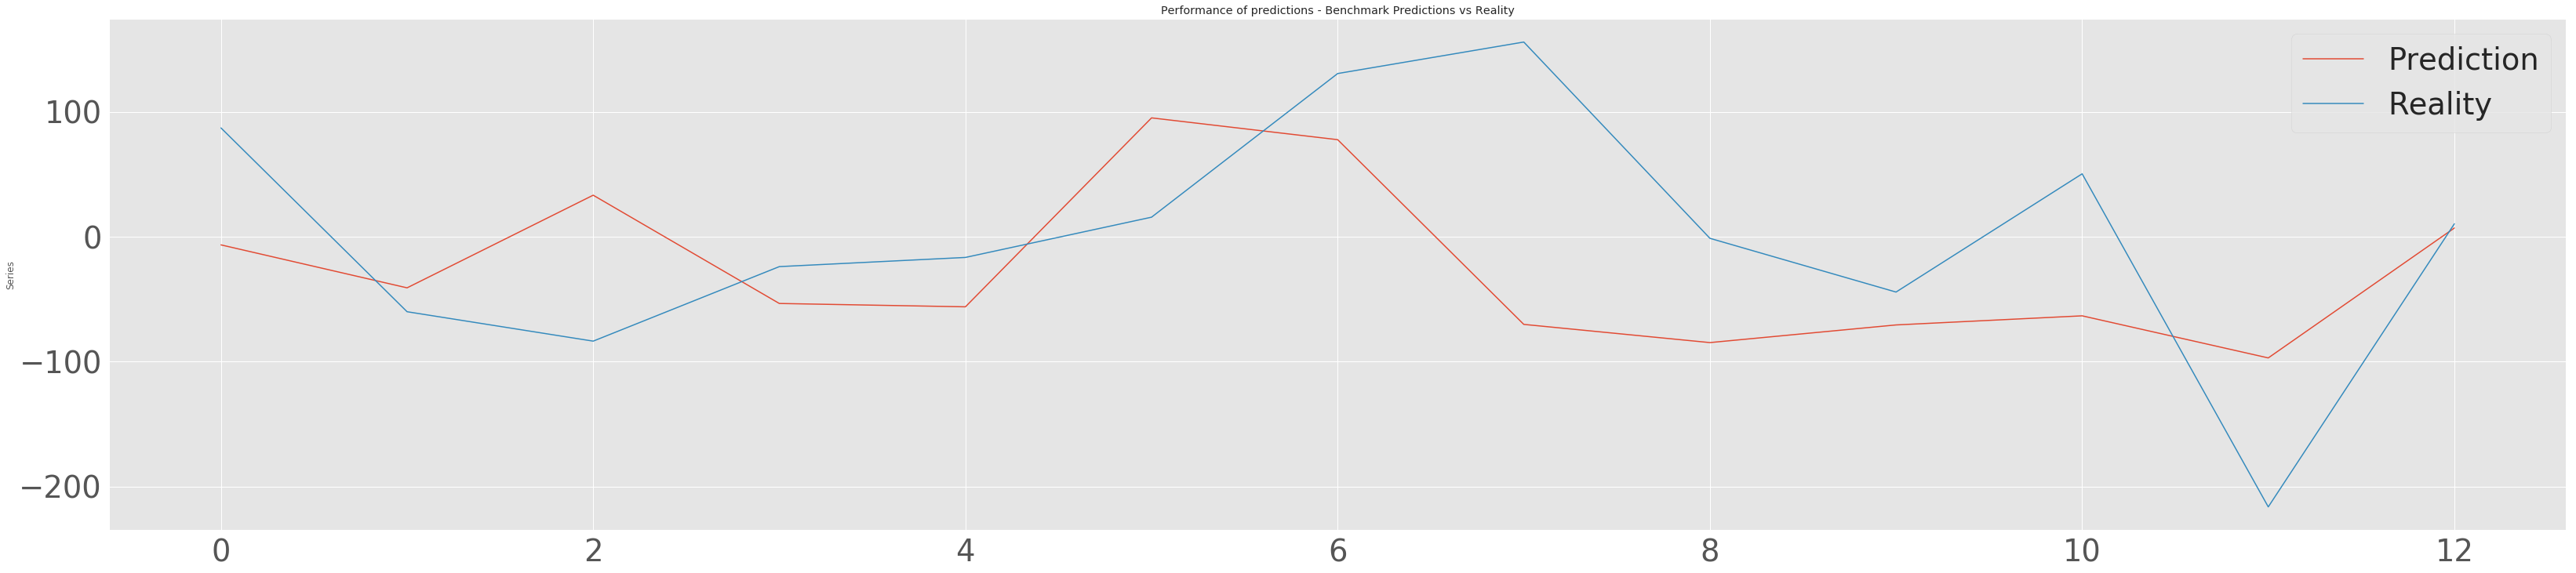

In [31]:
plt.style.use('ggplot')
plt.figure(figsize=(50, 12))
line_up, = plt.plot(prediction, label='Prediction')
line_down, = plt.plot(np.array(y_test), label='Reality')
plt.ylabel('Series')
plt.legend(handles=[line_up, line_down])
plt.title('Performance of predictions - Benchmark Predictions vs Reality')
plt.show()

In [32]:
def pred_df(data, number_of_days):
    data_pred = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=1)),columns = ["date"])
    for i in range(number_of_days):
        inter = pd.DataFrame(pd.Series(data["date"][data.shape[0]-1] + timedelta(days=i+2)),columns = ["date"])
        data_pred = pd.concat([data_pred,inter]).reset_index(drop=True)
    return data_pred
    
    

In [33]:
data_to_pred = pred_df(df_count,30)

In [34]:
def initialisation(data_lag, data_pred, model, xtrain, ytrain, number_of_days):
    model.fit(xtrain, ytrain)
    for i in range(number_of_days-1):
        lag1 = data_lag.tail(1)["diff"].values[0]
        lag2 = data_lag.tail(1)["lag1"].values[0]
        lag3 = data_lag.tail(1)["lag2"].values[0]
        lag4 = data_lag.tail(1)["lag3"].values[0]
        lag5 = data_lag.tail(1)["lag4"].values[0]
        lag6 = data_lag.tail(1)["lag5"].values[0]
        lag7 = data_lag.tail(1)["lag6"].values[0]
        lag8 = data_lag.tail(1)["lag7"].values[0]
        
        data_pred['weekday'] = data_pred['date'].apply(lambda x:x.weekday())
        weekday = data_pred['weekday'][0]
        
        row = pd.Series([lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,weekday]
                        ,['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        to_predict = pd.DataFrame(columns = ['lag1', 'lag2', 'lag3','lag4','lag5','lag6','lag7','lag8','weekday'])
        prediction = pd.DataFrame(columns = ['diff'])
        to_predict = to_predict.append([row])
        prediction = pd.DataFrame(model.predict(to_predict),columns = ['diff'])
        if i == 0:
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]
            
        if i > 0:
            last_predict = data_lag["Visits"][data_lag.shape[0]-1] + prediction.values[0][0]
            
        data_lag = pd.concat([data_lag,prediction.join(data_pred["date"]).join(to_predict)]).reset_index(drop=True)
        data_lag["Visits"][data_lag.shape[0]-1] = last_predict
        data_pred = data_pred[data_pred["date"]>data_pred["date"][0]].reset_index(drop=True)
        return data_lag
        

In [35]:
model_fin = AdaBoostRegressor(n_estimators = 5000, random_state = 42, learning_rate=0.01)

In [36]:
lagged = initialisation(lagged, data_to_pred, model_fin, xt, yt, 30)

In [37]:
lagged[lagged['diff']<0]
lagged.ix[(lagged.Visits < 0), 'Visits'] = 0


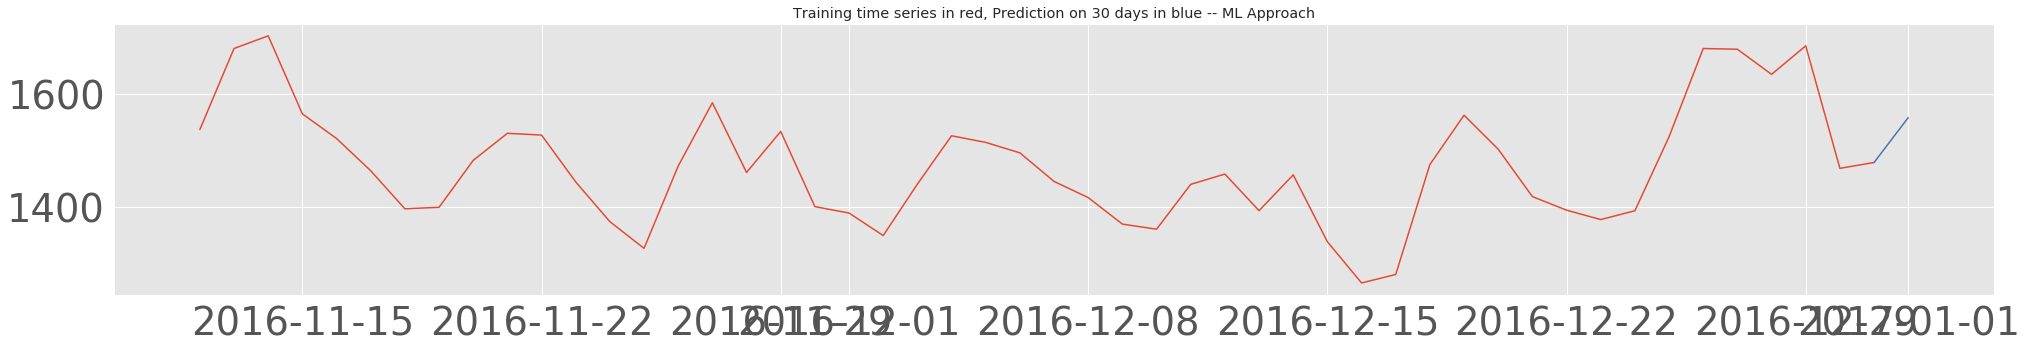

In [38]:
df_lagged = lagged[['Visits','date']]
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()

## Basic

For this model We will use a simple model with the average of the activity by weekdays.

In [39]:
lagged_basic = lagged[['date','Visits','weekday']]
lagged_basic_tr = lagged_basic[lagged_basic['date'] < last_date]
lagged_basic_pred = lagged_basic[lagged_basic['date'] >= last_date]
lagged_basic_pred.drop('Visits',inplace=True,axis=1)

In [45]:
lagged_basic_pred

,date,weekday
49,2016-12-31,5.0
50,2017-01-01,6.0


In [40]:
prediction_by_days = pd.DataFrame(lagged_basic.groupby(['weekday'])['Visits'].mean())
prediction_by_days.reset_index(drop=False,inplace=True)
prediction_by_days

,weekday,Visits
0,0.0,1557.934024
1,1.0,1527.514405
2,2.0,1474.061225
3,3.0,1437.088914
4,4.0,1364.716873
5,5.0,1420.017760
6,6.0,1533.340495


In [48]:
basic_pred = pd.merge(lagged_basic_pred,prediction_by_days,on='weekday')
basic_approach = pd.concat([lagged_basic_tr,basic_pred])

In [49]:
plot_basic = np.array(basic_approach[basic_approach['date'] > last_date].sort_values(by='date').Visits)

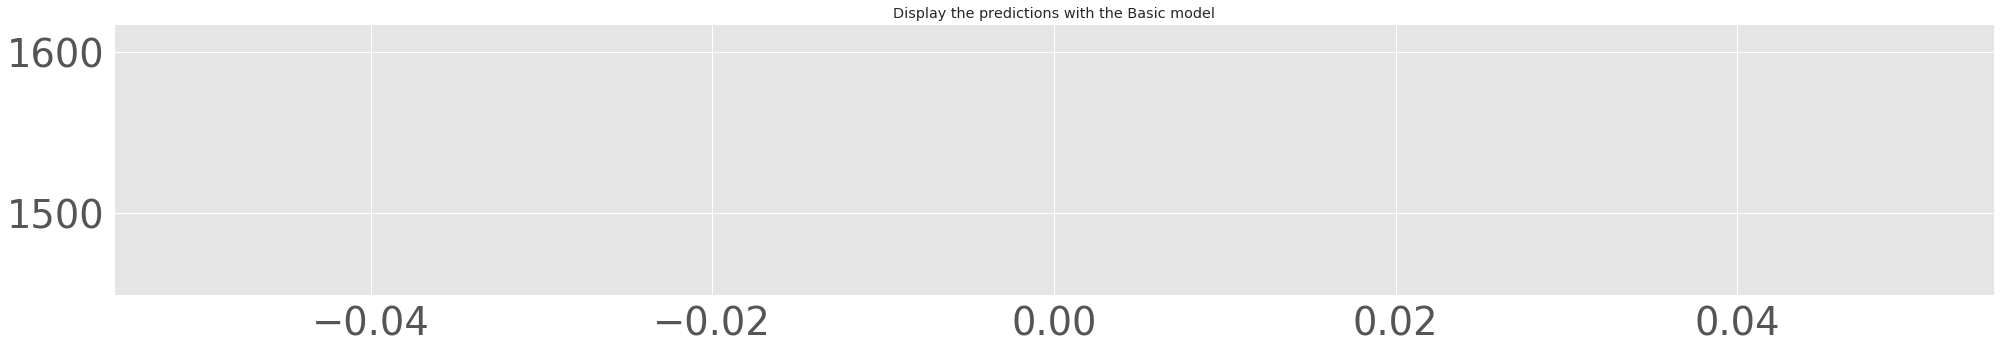

In [50]:
plt.figure(figsize=(30, 5))
plt.plot(plot_basic)
plt.title('Display the predictions with the Basic model')
plt.show()

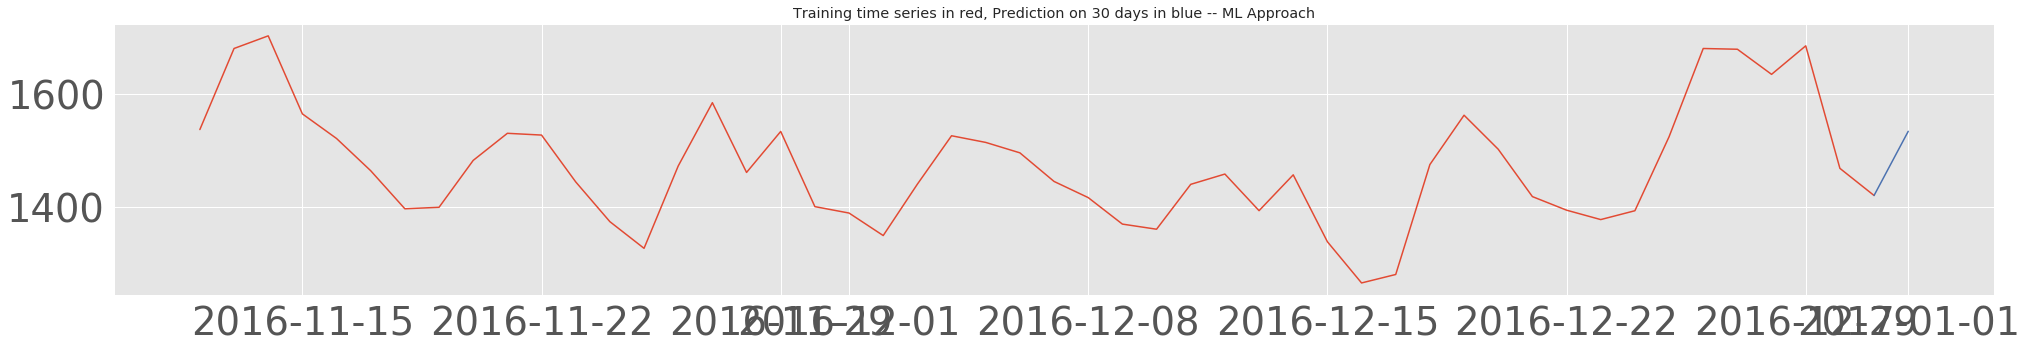

In [51]:
df_lagged = basic_approach[['Visits','date']].sort_values(by='date')
df_train = df_lagged[df_lagged['date'] <= last_date]
df_pred = df_lagged[df_lagged['date'] >= last_date]
plt.style.use('ggplot')
plt.figure(figsize=(30, 5))
plt.plot(df_train.date,df_train.Visits)
plt.plot(df_pred.date,df_pred.Visits,color='b')
plt.title('Training time series in red, Prediction on 30 days in blue -- ML Approach')
plt.show()

## ARIMA

## Prophet

## Keras

In [52]:
df_dl = times_series_means[['date','Visits']]

train_size = int(len(df_dl) * 0.80)
test_size = len(df_dl) - train_size
train, test = df_dl.iloc[0:train_size,:], df_dl.iloc[train_size:len(df_dl),:]
print(len(train), len(test))

40 10


In [53]:
look_back = 1
def create_dataset(dataset, look_back):
    dataX = []
    dataY = []
    for i in range(len(dataset)-look_back-1):
        a = dataset.iloc[i:(i+look_back), 1].values[0]
        b = dataset.iloc[i+look_back, 1]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

In [54]:
trainX, trainY = create_dataset(train, look_back)

In [55]:
trainX

array([1536.47175653, 1679.63058931, 1701.94183062, 1564.17222839,
       1520.67395867, 1463.75193666, 1396.54414535, 1399.1704118 ,
       1482.0187392 , 1529.84458489, 1526.72394436, 1444.04389824,
       1373.81463827, 1326.70910719, 1472.10722375, 1583.90313338,
       1460.71908225, 1533.142157  , 1400.35571666, 1389.00719134,
       1349.26677319, 1440.03653068, 1525.51159668, 1513.75852789,
       1495.34191969, 1444.83066422, 1416.28916166, 1369.50114278,
       1360.45121537, 1439.70342517, 1457.87765412, 1393.21735652,
       1456.49566174, 1338.35625066, 1265.57184958, 1280.52359651,
       1474.68220684, 1561.78993148])

In [58]:
from keras.models import Sequential
from keras.layers import Dense

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.fit(trainX, trainY, epochs=150, batch_size=2, verbose=0)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [59]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f MAE)' % (trainScore, trainScore))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f MAE)' % (testScore, testScore))

Train Score: 66.13 MSE (66.13 MAE)
Test Score: 83.56 MSE (83.56 MAE)


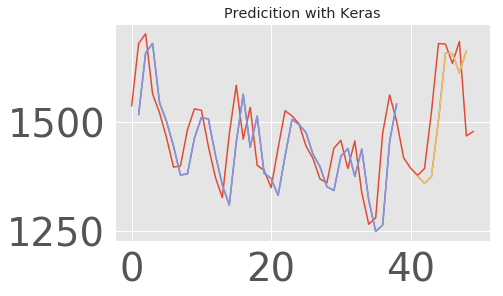

In [60]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_dl)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_dl)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df_dl)-1, :] = testPredict
 
# plot baseline and predictions
plt.plot(np.array(df_dl.Visits))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Predicition with Keras')
plt.show()
